<a href="https://colab.research.google.com/github/epodkwan/growthfunction/blob/main/bsplinetrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from typing import Sequence
import jax
import optax
import numpy as np
import jax.numpy as jnp
from jax import jit,random,vmap
from flax import linen as nn
from flax.training import train_state,checkpoints
import matplotlib.pyplot as plt

In [3]:
class SimpleMLP(nn.Module):
    features:Sequence[int]
    nodes:int

    @nn.compact
    def __call__(self,inputs):
        x=inputs
        for i,feat in enumerate(self.features):
            x=nn.Dense(feat)(x)
            x=nn.relu(x)
        t=nn.Dense(nodes-1)(x)
        c=nn.Dense(nodes+1)(x)
        return t,c

In [4]:
def npy_loader(path):
    return jnp.load(path)

In [5]:
@jit
def _deBoorVectorized(x,t,c):
    k=jnp.digitize(x,t)-1
    d=[c[j+k-3] for j in range(0,4)]
    for r in range(1,4):
        for j in range(3,r-1,-1):
            alpha=(x-t[j+k-3])/(t[j+1+k-r]-t[j+k-3])
            d[j]=(1-alpha)*d[j-1]+alpha*d[j]
    return d[3]

In [6]:
layer_sizes=[64,256,256]
nodes=5
learning_rate=1e-6
epochs=25000
model=SimpleMLP(features=layer_sizes,nodes=nodes)
temp=jnp.ones(2)
params=model.init(random.PRNGKey(0),temp)
tx=optax.adam(learning_rate=learning_rate)
opt_state=tx.init(params)
deBoor=vmap(_deBoorVectorized,in_axes=(None,0,0))

In [7]:
@jit
def mse_loss(params,x,y_ref,a):
    t,c=model.apply(params,x)
    t=jnp.concatenate([jnp.zeros((t.shape[0],3)),jnp.cumsum(jax.nn.softmax(t),axis=1),jnp.ones((t.shape[0],3))],axis=1)
    preds=deBoor(a,t,c)
    diff=preds-y_ref
    return jnp.mean(diff*diff)

In [8]:
@jit
def train_step(params,opt_state,x,y_ref,a):
    loss,grads=jax.value_and_grad(mse_loss,argnums=0)(params,x,y_ref,a)
    updates,opt_state=tx.update(grads,opt_state)
    params=optax.apply_updates(params,updates)
    return loss,params,opt_state

In [9]:
@jit
def epoch_step(x_train,y_train,params,opt_state,order,a):
    order=random.permutation(random.PRNGKey(i),order)
    train_loss=0
    for j in range(25):
        x_batch=x_train[order[32*j:32*(j+1)],:]
        y_batch=y_train[order[32*j:32*(j+1)],:]
        loss,params,opt_state=train_step(params,opt_state,x_batch,y_batch,a)
        train_loss=train_loss+loss
    return train_loss,params

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
input_data=npy_loader("/content/drive/My Drive/Colab Notebooks/cosmo.npy")
raw_input_result=npy_loader("/content/drive/My Drive/Colab Notebooks/combined.npy")
a=npy_loader("/content/drive/My Drive/Colab Notebooks/999.npy")[0,:]
input_result=jnp.log(raw_input_result)
x_train=jnp.stack((input_data[0:800,0],input_data[0:800,2]),axis=1)
y_train=input_result[0:800,:]
x_validate=jnp.stack((input_data[800:900,0],input_data[800:900,2]),axis=1)
y_validate=input_result[800:900,:]

1000 nan
2000 nan
3000 nan
4000 nan
5000 nan
6000 nan
7000 nan
8000 nan
9000 nan
10000 nan
11000 nan
12000 nan
13000 nan
14000 nan
15000 nan
16000 nan
17000 nan
18000 nan
19000 nan
20000 nan
21000 nan
22000 nan
23000 nan
24000 nan
25000 nan
Training ended


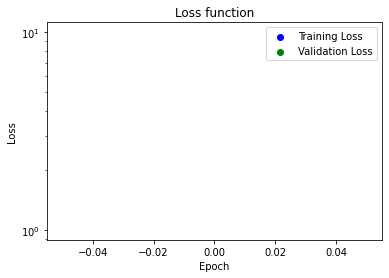

In [12]:
order=jnp.arange(800)
for i in range(epochs):
    train_loss,params=epoch_step(x_train,y_train,params,opt_state,order,a)
    if i % 1000 == 999:
        train_loss=train_loss/25
        validate_loss=mse_loss(params,x_validate,y_validate,a)
        print((i+1),validate_loss)
        plt.scatter((i+1),train_loss,c='b')
        plt.scatter((i+1),validate_loss,c='g')
print("Training ended")
state=train_state.TrainState.create(apply_fn=model.apply,params=params,tx=tx)
checkpoints.save_checkpoint(ckpt_dir="/content/drive/My Drive/Colab Notebooks",target=state,step=0,overwrite=True)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss function")
plt.legend(["Training Loss","Validation Loss"])
plt.savefig("/content/drive/My Drive/Colab Notebooks/loss.png")
drive.flush_and_unmount()

In [13]:
x_test=jnp.stack((input_data[900:1000,0],input_data[900:1000,2]),axis=1)
y_test=raw_input_result[900:1000,:]
t_test,c_test=model.apply(params,x_test)
t_test=jnp.concatenate([jnp.zeros((t_test.shape[0],3)),jnp.cumsum(jax.nn.softmax(t_test),axis=1),jnp.ones((t_test.shape[0],3))],axis=1)
y_pred=jnp.exp(deBoor(a,t_test,c_test))
print(y_pred)
error=abs(y_pred/y_test-1)
print("Max error =",jnp.max(error)*100,"%")

[[       nan        nan        nan ... 0.97537136 0.98755217 0.99971473]
 [       nan        nan        nan ... 0.97891885 0.9895562  1.000129  ]
 [       nan        nan        nan ... 0.9837239  0.99201024 1.0001837 ]
 ...
 [       nan        nan        nan ... 0.9834242  0.99180746 1.0000781 ]
 [       nan        nan        nan ... 0.98699725 0.9935924  1.000063  ]
 [       nan        nan        nan ... 0.9770421  0.98861766 1.0001576 ]]
Max error = nan %
